In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
# from keras import layers


from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K


from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random



In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("Not enough GPU hardware devices available")
else:
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


2023-06-10 18:28:52.759545: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-06-10 18:28:52.788811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-10 18:28:52.789067: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 with Max-Q Design computeCapability: 7.5
coreClock: 1.23GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 357.69GiB/s
2023-06-10 18:28:52.789239: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-06-10 18:28:52.790531: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-10 18:28:52.791798: I tensorflow/st

In [3]:
# tf.debugging.set_log_device_placement(True)       # Will print the log information of every execution of tensorflow, mainly about 

In [4]:
#Size of our input images
# SIZE = 128        # It was this value at the beginning, but the image display was poor. 
SIZE = 160
# SIZE = 228          # It was 224, but in order for the current autoencoder model configuration work adequately, we changed it 228

# Setting the training and testing datasets 

ImageDataGenerator.flow_from_directory: Takes the path to a directory and generates batches of augmented data.

In [5]:
class CenterCropImageDataGenerator(ImageDataGenerator):
    def __init__(self, crop_height, crop_width, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.crop_height = crop_height
        self.crop_width = crop_width
        self.preprocess_input()

    def preprocess_input(self, x, **kwargs):
        crops = []
        for img in x:
            crop = tf.image.central_crop(img, self.crop_height / self.crop_width)
            crops.append(crop)
        crops = np.array(crops)
        crops = crops.astype(np.float32) / 255.0  # Rescale pixel values
        return crops


In [6]:
# batch_size = 64
batch_size = 32
datagen = CenterCropImageDataGenerator(crop_height=20, crop_width=20, rescale=1./255)

train_generator = datagen.flow_from_directory(
    "../../Images/june5Night/Positive/",         # For home laptop
    # "../../../BottleStoodUp_atNight/Positive/",          # For work laptop
    target_size=(20, 20),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'          # Class used for working with Autoencoders
    
    )

Found 295 images belonging to 1 classes.


In [7]:
# validation_generator = datagen.flow_from_directory(
#     "../../Images/june5Night/Positive_val/",     # For home laptop
#     # "../../../BottleStoodUp_atNight/Positive_val/",           # For work lpatop   
#     target_size=(SIZE, SIZE),
#     batch_size=batch_size,
#     shuffle = False,
#     class_mode='input'
#     )


In [8]:
# anomaly_generator = datagen.flow_from_directory(
#     "../../Images/june5Night/Anomalies2.0/",         # For home laptop
#     # "../../../BottleStoodUp_atNight/Anomalies2.0/",           # For work lpatpo
#     target_size=(SIZE, SIZE),
#     batch_size=batch_size,
#     shuffle = False,
#     class_mode='input'
#     )


In [9]:
# test_set_generator = datagen.flow_from_directory(
#     "../../Images/june5Night/Evaluation/",       # For home laptop
#     # "../../../BottleStoodUp_atNight/Evaluation/",             # For work laptop  
#     target_size=(SIZE, SIZE),
#     batch_size=batch_size,
#     shuffle = False,
#     class_mode='binary'
#     )


# Showing one sample of the training set images

In [10]:
print(len(train_generator))

10


Grabbing only one image of one batch of the training set.

In [11]:
images_in_batch = next(train_generator)[0]
print(type(images_in_batch))
print(len(images_in_batch))
print(tf.reduce_min(images_in_batch), tf.reduce_max(images_in_batch))

<class 'numpy.ndarray'>
32


2023-06-10 18:28:53.551803: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-06-10 18:28:53.571825: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2599990000 Hz
2023-06-10 18:28:53.572423: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f592c000db0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-06-10 18:28:53.572436: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-06-10 18:28:53.645012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-10 18:28:53.645343: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x618cd00 initialized for platform CUDA (this does not guarantee that XLA will

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


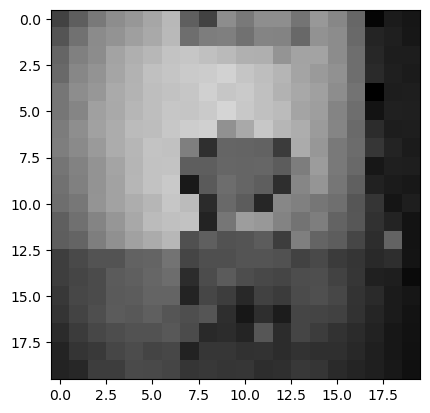

In [12]:
single_img = images_in_batch[0]
plt.imshow(single_img)

In [13]:
print(single_img.shape)

(20, 20, 3)


In [14]:
print(single_img)

[[[0.25882354 0.25882354 0.25882354]
  [0.36862746 0.36862746 0.36862746]
  [0.47450984 0.47450984 0.47450984]
  ...
  [0.01960784 0.01960784 0.01960784]
  [0.10588236 0.10588236 0.10588236]
  [0.08627451 0.08627451 0.08627451]]

 [[0.32941177 0.32941177 0.32941177]
  [0.4431373  0.4431373  0.4431373 ]
  [0.54509807 0.54509807 0.54509807]
  ...
  [0.14117648 0.14117648 0.14117648]
  [0.12156864 0.12156864 0.12156864]
  [0.09019608 0.09019608 0.09019608]]

 [[0.39607847 0.39607847 0.39607847]
  [0.5019608  0.5019608  0.5019608 ]
  [0.54901963 0.54901963 0.54901963]
  ...
  [0.15294118 0.15294118 0.15294118]
  [0.1137255  0.1137255  0.1137255 ]
  [0.1137255  0.1137255  0.1137255 ]]

 ...

 [[0.16862746 0.16862746 0.16862746]
  [0.23137257 0.23137257 0.23137257]
  [0.2784314  0.2784314  0.2784314 ]
  ...
  [0.13333334 0.13333334 0.13333334]
  [0.09019608 0.09019608 0.09019608]
  [0.07058824 0.07058824 0.07058824]]

 [[0.13725491 0.13725491 0.13725491]
  [0.20392159 0.20392159 0.20392159]


This is bullshit, it does rescale the pixel values but it doesn't crop. 